<a href="https://colab.research.google.com/github/tops201/project_507/blob/main/507_508/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

from google.colab import files

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

In [3]:
#fetch dataset

data_file = files.upload() #for google colab

df = pd.read_excel(io.BytesIO(data_file["well3.xlsx"]), index_col="DATEPRD") #for google colab
#df = pd.read_excel("well3.xlsx", index_col="DATEPRD") #for local IDE

date = df.index

df.head()

Saving well3.xlsx to well3.xlsx


,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
DATEPRD,,,,,,,,,,,
2008-02-12,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107,284.65,38888.67,385.01
2008-02-13,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148,1869.70,285246.16,7.13
2008-02-14,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465,3124.09,509954.88,1.16
2008-02-15,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990,2608.28,383426.67,0.97
2008-02-16,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026,3051.80,418474.00,4.89


In [4]:
#function to plot the a series
def plot_series(x, y, format="-", start=None, end=None, label=None):
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Oil Volume")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

#clear session 
def refresh():
  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)

class ResetStatesCallback(Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

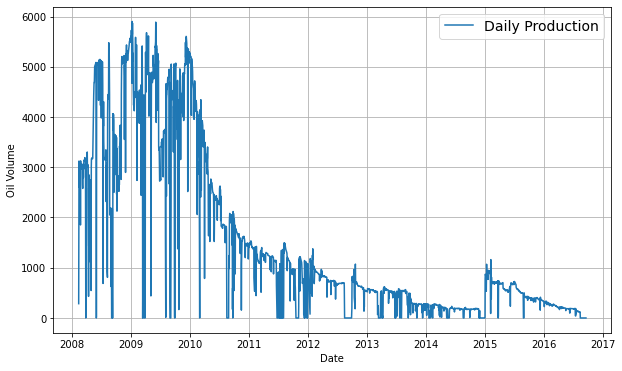

array([ 284.65, 1869.7 , 3124.09, ...,    0.  ,    0.  ,    0.  ])

In [62]:
oil_data = df.BORE_OIL_VOL.to_numpy()
oil_cum = np.cumsum(oil_data)

plt.figure(figsize=(10, 6))
plot_series(date, oil_data, label="Daily Production")
plt.show()

oil_data

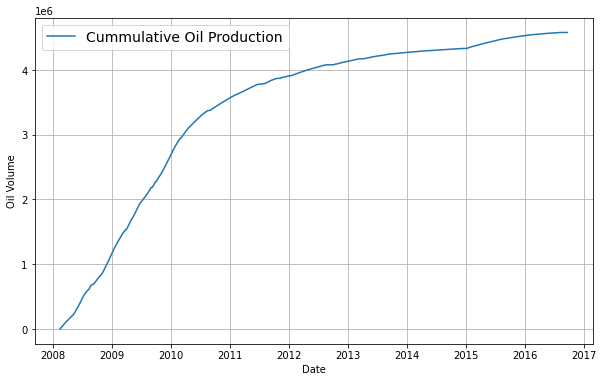

In [63]:
plt.figure(figsize=(10, 6))
plot_series(date, oil_cum, label="Cummulative Oil Production")
plt.show()

In [11]:
#split the time series into training and validation sets
split_date = 2750

date_train = date[:split_date]
date_valid = date[split_date:]

x_train = oil_data[:split_date]
x_valid = oil_data[split_date:]

print(x_train.shape, x_valid.shape, date_train.shape, date_valid.shape)

(2750,) (306,) (2750,) (306,)


#NAIVE Forecast

In [24]:
naive_forecast = oil_data[split_date - 1:-1]

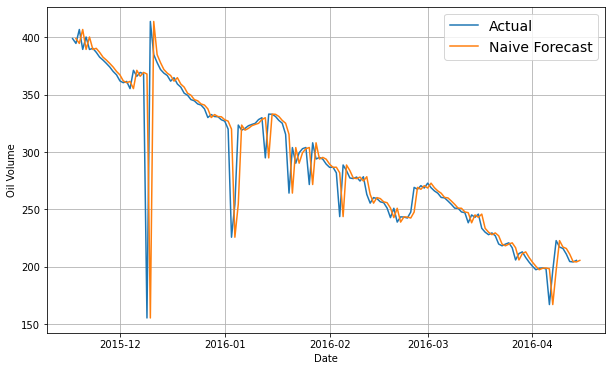

In [61]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, start=0, end=150, label="Actual")
plot_series(date_valid, naive_forecast, start=1, end=151, label="Naive Forecast")

In [17]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

9.511960784313725

#Moving Average

In [18]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

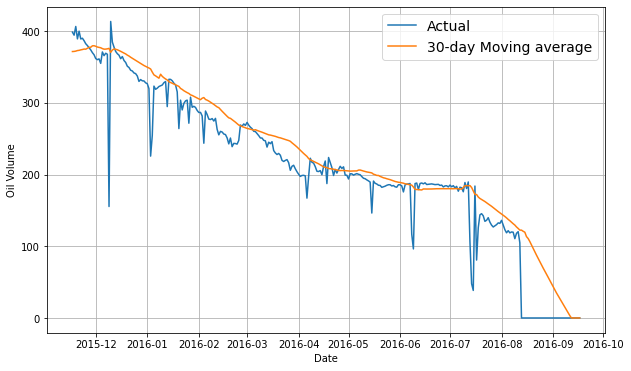

In [20]:
moving_avg = moving_average_forecast(oil_data, 30)[split_date - 30:]

plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, moving_avg, label="30-day Moving average")

In [21]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

22.083657952074432

#Linear Model

In [26]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [27]:
refresh()

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
85/85 [==============================] - 1s 6ms/step - loss: 778.3753 - mae: 778.8743 - val_loss: 122.4524 - val_mae: 122.9415
Epoch 2/100
85/85 [==============================] - 0s 5ms/step - loss: 382.0746 - mae: 382.5733 - val_loss: 25.5324 - val_mae: 26.0173
Epoch 3/100
85/85 [==============================] - 1s 5ms/step - loss: 612.1008 - mae: 612.6000 - val_loss: 58.9531 - val_mae: 59.4422
Epoch 4/100
85/85 [==============================] - 1s 5ms/step - loss: 882.9415 - mae: 883.4404 - val_loss: 93.3159 - val_mae: 93.8050
Epoch 5/100
85/85 [==============================] - 1s 5ms/step - loss: 1069.6411 - mae: 1070.1406 - val_loss: 124.3494 - val_mae: 124.8386
Epoch 6/100
85/85 [==============================] - 1s 5ms/step - loss: 1266.6591 - mae: 1267.1583 - val_loss: 60.7281 - val_mae: 61.2173
Epoch 7/100
85/85 [==============================] - 1s 5ms/step - loss: 994.4450 - mae: 994.9440 - val_loss: 11.0218 - val_mae: 11.4944
Epoch 8/100
85/85 [==============

In [28]:
refresh()

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 783.8070 - mae: 784.3059
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 364.8394 - mae: 365.3379
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 317.1571 - mae: 317.6563
Epoch 4/100
85/85 [==============================] - 0s 4ms/step - loss: 282.8652 - mae: 283.3636
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 251.1218 - mae: 251.6181
Epoch 6/100
85/85 [==============================] - 0s 4ms/step - loss: 259.2585 - mae: 259.7569
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 244.3214 - mae: 244.8182
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 205.7978 - mae: 206.2937
Epoch 9/100
85/85 [==============================] - 0s 4ms/step - loss: 254.8600 - mae: 255.3583
Epoch 10/100
85/85 [==============================] - 0s 4ms/step - loss: 245.1728 - mae: 245.6699
Epoch 11/100
85/85 

1e-06

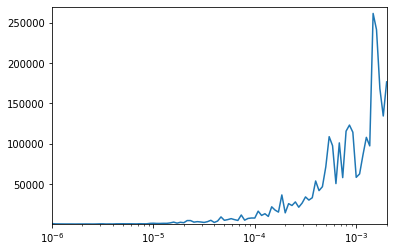

In [36]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 2e-3, 210, 270000])

min(history.history["lr"])

In [37]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
85/85 [==============================] - 1s 6ms/step - loss: 1043.2412 - mae: 1043.7405 - val_loss: 32.1371 - val_mae: 32.6235
Epoch 2/500
85/85 [==============================] - 1s 5ms/step - loss: 466.4828 - mae: 466.9814 - val_loss: 25.9973 - val_mae: 26.4793
Epoch 3/500
85/85 [==============================] - 1s 5ms/step - loss: 394.7640 - mae: 395.2624 - val_loss: 19.6025 - val_mae: 20.0848
Epoch 4/500
85/85 [==============================] - 1s 5ms/step - loss: 325.8033 - mae: 326.3010 - val_loss: 18.0865 - val_mae: 18.5715
Epoch 5/500
85/85 [==============================] - 1s 5ms/step - loss: 302.9861 - mae: 303.4847 - val_loss: 18.9958 - val_mae: 19.4818
Epoch 6/500
85/85 [==============================] - 1s 6ms/step - loss: 285.0542 - mae: 285.5517 - val_loss: 17.7846 - val_mae: 18.2655
Epoch 7/500
85/85 [==============================] - 1s 5ms/step - loss: 251.8130 - mae: 252.3111 - val_loss: 14.8984 - val_mae: 15.3792
Epoch 8/500
85/85 [====================

In [38]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [40]:
lin_forecast = model_forecast(model, oil_data[split_date - window_size:-1], window_size)[:, 0]

In [41]:
lin_forecast.shape

(306,)

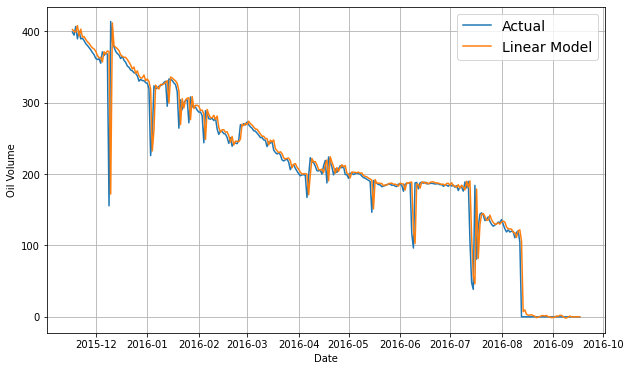

In [44]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, lin_forecast, label="Linear Model")

In [46]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

10.155754

#  MLP

In [47]:
refresh()

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 643.0623 - mae: 643.5604
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 330.5939 - mae: 331.0923
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 324.4507 - mae: 324.9488
Epoch 4/100
85/85 [==============================] - 0s 4ms/step - loss: 317.6391 - mae: 318.1368
Epoch 5/100
85/85 [==============================] - 0s 4ms/step - loss: 309.9660 - mae: 310.4639
Epoch 6/100
85/85 [==============================] - 0s 4ms/step - loss: 304.3207 - mae: 304.8182
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 299.6580 - mae: 300.1563
Epoch 8/100
85/85 [==============================] - 0s 4ms/step - loss: 290.8898 - mae: 291.3870
Epoch 9/100
85/85 [==============================] - 0s 4ms/step - loss: 289.0251 - mae: 289.5227
Epoch 10/100
85/85 [==============================] - 1s 4ms/step - loss: 278.4656 - mae: 278.9632
Epoch 11/100
85/85 

1e-07

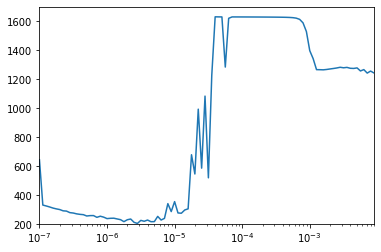

In [54]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 9e-3, 200, 1700])
min(history.history["lr"])

In [55]:
refresh()

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
85/85 [==============================] - 1s 6ms/step - loss: 435.1540 - mae: 435.6519 - val_loss: 29.4284 - val_mae: 29.9173
Epoch 2/500
85/85 [==============================] - 1s 5ms/step - loss: 272.5620 - mae: 273.0599 - val_loss: 19.8977 - val_mae: 20.3837
Epoch 3/500
85/85 [==============================] - 1s 5ms/step - loss: 251.8521 - mae: 252.3488 - val_loss: 12.2011 - val_mae: 12.6794
Epoch 4/500
85/85 [==============================] - 1s 5ms/step - loss: 223.7565 - mae: 224.2534 - val_loss: 11.0370 - val_mae: 11.5080
Epoch 5/500
85/85 [==============================] - 1s 5ms/step - loss: 217.9648 - mae: 218.4610 - val_loss: 12.2744 - val_mae: 12.7569
Epoch 6/500
85/85 [==============================] - 1s 5ms/step - loss: 231.7369 - mae: 232.2343 - val_loss: 10.1072 - val_mae: 10.5810
Epoch 7/500
85/85 [==============================] - 1s 5ms/step - loss: 213.4125 - mae: 213.9100 - val_loss: 13.0313 - val_mae: 13.5138
Epoch 8/500
85/85 [======================

In [57]:
dense_forecast = model_forecast(
    model,
    oil_data[split_date - window_size:-1],
    window_size)[:, 0]

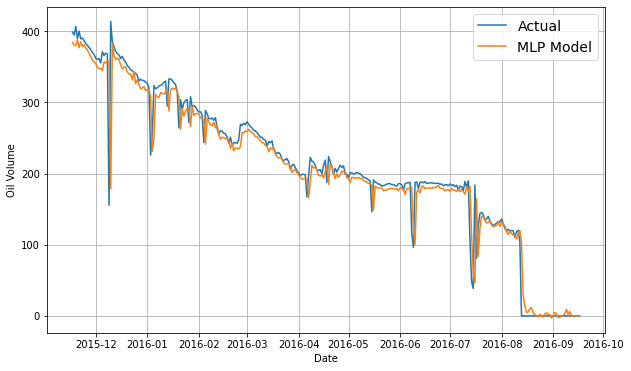

In [59]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, dense_forecast, label="MLP Model")

In [60]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

12.390502

# RNN Model - LSTM

In [ ]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
refresh()

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        #Lambda(lambda x: x * 200.0)
    
    ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

Epoch 1/100
91/91 [==============================] - 4s 14ms/step - loss: 1650.9897 - mae: 1651.4656
Epoch 2/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9862 - mae: 1651.4637
Epoch 3/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9840 - mae: 1651.4597
Epoch 4/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9813 - mae: 1651.4573
Epoch 5/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9788 - mae: 1651.4546
Epoch 6/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9760 - mae: 1651.4518
Epoch 7/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9733 - mae: 1651.4495
Epoch 8/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9706 - mae: 1651.4459
Epoch 9/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9683 - mae: 1651.4443
Epoch 10/100
91/91 [==============================] - 1s 14ms/step - loss: 1650.9657 - mae:

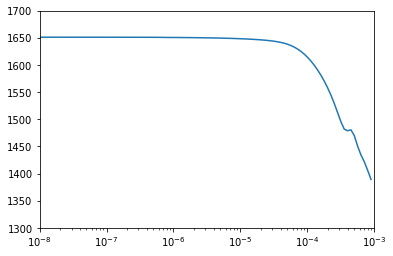

1389.3135986328125

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 1300, 1700])
plt.show()

min(history.history["loss"])

In [ ]:
refresh()

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = Sequential([
                    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1),
        #Lambda(lambda x: x * 200.0)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

model.fit(train_set, epochs=500, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
91/91 [==============================] - 5s 22ms/step - loss: 1650.7976 - mae: 1651.2678 - val_loss: 211.7826 - val_mae: 212.2350
Epoch 2/500
91/91 [==============================] - 1s 14ms/step - loss: 1650.2924 - mae: 1650.7756 - val_loss: 211.3517 - val_mae: 211.8172
Epoch 3/500
91/91 [==============================] - 1s 15ms/step - loss: 1649.9385 - mae: 1650.4302 - val_loss: 211.0211 - val_mae: 211.4965
Epoch 4/500
91/91 [==============================] - 1s 14ms/step - loss: 1649.6221 - mae: 1650.1168 - val_loss: 210.7117 - val_mae: 211.1938
Epoch 5/500
91/91 [==============================] - 1s 14ms/step - loss: 1649.3231 - mae: 1649.8185 - val_loss: 210.4261 - val_mae: 210.9128
Epoch 6/500
91/91 [==============================] - 1s 15ms/step - loss: 1649.0404 - mae: 1649.5376 - val_loss: 210.1543 - val_mae: 210.6441
Epoch 7/500
91/91 [==============================] - 1s 14ms/step - loss: 1648.7684 - mae: 1649.2645 - val_loss: 209.8997 - val_mae: 210.3918
Epoch 

In [ ]:
#load best model
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
#forcast
rnn_forecast = model.predict(oil_data[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_date - 1:-1, 0]

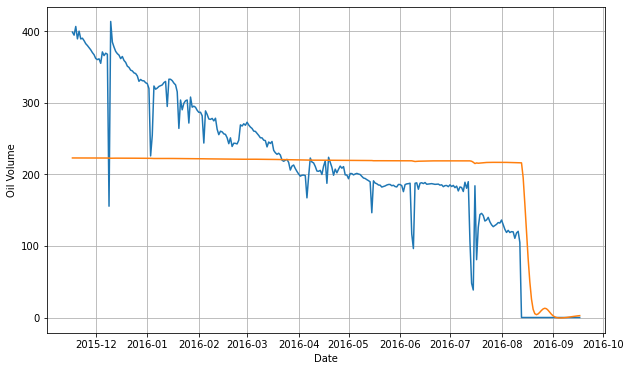

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid)
plot_series(date_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

57.93529

#univariate

In [ ]:
# specify the window size
n_steps = 7

# split into samples
X, y = split_sequence(values, n_steps)

# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# define model
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

In [ ]:
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal'))

In [ ]:
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the model
model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

# make a prediction


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())